# Модель предсказания срывов поставок

## Модули

In [67]:
# Модели
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Тюнинг гиперпараметров
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import optuna as opt

# Инструменты анализа данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Пайплайны
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Препроцессинг данных
from sklearn.preprocessing import StandardScaler, RobustScaler, SplineTransformer, PolynomialFeatures
from sklearn.decomposition import PCA, KernelPCA

# Отбор фич
from sklearn.feature_selection import RFE

# Кросс-валидация
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score

# Система
import os
import re

# Отображение
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

## Анализ данных

### Статистическая характеристика

In [22]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, 'data/train_AIC.csv')
TEST_DATASET = os.path.join(ROOT, 'data/test_AIC.csv')

# Загружаем датасеты
train_df = pd.read_csv(TRAIN_DATASET)
test_df = pd.read_csv(TEST_DATASET)

In [13]:
# Случайные записи тренировочного датасета
train_df.sample(10, random_state=42)

,Поставщик,Материал,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,Вариант поставки,НРП,Длительность,До поставки,Месяц1,Месяц2,Месяц3,День недели 2,Сумма,Количество позиций,Количество,Количество обработчиков 7,Количество обработчиков 15,Количество обработчиков 30,Согласование заказа 1,Согласование заказа 2,Согласование заказа 3,Изменение даты поставки 7,Изменение даты поставки 15,Изменение даты поставки 30,Отмена полного деблокирования заказа на закупку,Изменение позиции заказа на закупку: изменение даты поставки на бумаге,Изменение позиции заказа на закупку: дата поставки,Количество циклов согласования,Количество изменений после согласований,Дней между 0_1,Дней между 1_2,Дней между 2_3,Дней между 3_4,Дней между 4_5,Дней между 5_6,Дней между 6_7,Дней между 7_8,y
160758,1000,1898,3,2,1,1,189,1,1,5,2,0.0,120,119,11,3,11,6,7.518876,9,2.000,8,8,8,1,1,1,0.0,0.0,0.0,0,0,0,1.0,12,0.0,3.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0
139197,40,27439,4,8,1,1,26,1,1,4,2,0.0,63,55,1,4,2,4,5.798355,18,1.000,8,8,8,2,2,1,0.0,0.0,0.0,0,0,0,1.0,18,3.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0
142011,1,240,10,18,1,8,28,1,1,4,2,1.0,31,18,7,8,7,0,5.528421,18,3600.000,6,6,6,3,2,2,3.0,3.0,3.0,1,0,1,2.0,17,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,0
133759,1063,12434,1,1,35,21,159,14,1,45,2,0.0,9,0,5,5,5,6,5.631166,18,2.000,3,3,3,0,0,0,0.0,0.0,0.0,0,0,0,0.0,5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
179232,237,27439,2,3,1,1,192,1,1,6,1,0.0,65,65,4,6,4,0,4.764206,1,2.000,5,5,5,1,1,1,0.0,0.0,0.0,0,0,0,1.0,10,6.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
215909,1461,27439,3,6,1,1,112,1,1,41,2,0.0,130,130,11,3,11,1,7.421463,1,1.000,6,6,6,1,1,1,0.0,0.0,0.0,0,0,0,1.0,11,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
884,76,10693,5,2,1,1,3,1,1,17,1,0.0,42,32,8,9,8,5,4.702058,8,2.000,7,7,7,1,1,1,1.0,1.0,1.0,0,1,1,1.0,13,0.0,0.0,0.0,3.0,0.0,-1.0,-1.0,-1.0,0
67071,149,11167,3,6,3,1,10,3,1,16,1,0.0,63,57,4,6,4,2,6.504247,3,40.000,8,8,9,5,3,3,6.0,6.0,6.0,2,2,3,3.0,33,21.0,0.0,0.0,0.0,0.0,-1.0,-1.0,15.0,0
149663,367,429,1,4,1,1,95,1,4,65,2,1.0,30,30,8,9,8,3,4.458210,2,1.174,7,7,7,1,1,1,0.0,0.0,0.0,0,0,0,1.0,10,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0
13505,62,9582,5,2,1,1,25,1,1,33,1,0.0,350,43,1,12,1,3,8.223091,267,1012.000,23,23,23,9,8,7,0.0,0.0,0.0,8,0,0,8.0,104,5.0,19.0,20.0,1.0,1.0,-1.0,-1.0,-1.0,0


In [5]:
# Статистическая характеристика
train_df.describe()

,Поставщик,Материал,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,Вариант поставки,НРП,Длительность,До поставки,Месяц1,Месяц2,Месяц3,День недели 2,Сумма,Количество позиций,Количество,Количество обработчиков 7,Количество обработчиков 15,Количество обработчиков 30,Согласование заказа 1,Согласование заказа 2,Согласование заказа 3,Изменение даты поставки 7,Изменение даты поставки 15,Изменение даты поставки 30,Отмена полного деблокирования заказа на закупку,Изменение позиции заказа на закупку: изменение даты поставки на бумаге,Изменение позиции заказа на закупку: дата поставки,Количество циклов согласования,Количество изменений после согласований,Дней между 0_1,Дней между 1_2,Дней между 2_3,Дней между 3_4,Дней между 4_5,Дней между 5_6,Дней между 6_7,Дней между 7_8,y
count,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000
mean,258.764502,12178.154022,2.491564,7.406547,4.122280,3.007204,46.753933,2.715449,1.651298,25.692604,1.654244,0.312338,58.479373,48.117862,6.539493,6.281027,6.400391,2.721636,6.034339,14.489080,343.795552,7.060933,7.179347,7.263796,1.574800,1.426187,1.171009,1.572898,1.576942,1.579418,0.469044,0.589898,0.615249,1.391284,13.974707,11.459787,1.675524,0.980649,0.175053,0.012716,-0.343231,-0.515613,1.710564,0.143720
std,432.503252,11046.424340,2.320779,5.590122,6.007215,3.648362,56.888056,3.074011,1.623117,28.097748,0.495729,0.463831,43.646171,40.167039,3.599915,3.374321,3.559672,1.823799,1.145668,23.522543,5613.312425,2.019514,2.018921,2.014358,1.486648,1.027119,0.972502,2.573085,2.578174,2.581892,0.967208,1.049886,1.043193,0.972455,32.803414,28.579707,9.039413,6.040917,2.914853,2.463346,6.465780,5.665595,14.109760,0.350806
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.485452,1.000000,0.001000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,14.000000,1572.000000,1.000000,3.000000,1.000000,1.000000,7.000000,1.000000,1.000000,6.000000,1.000000,0.000000,30.000000,21.000000,3.000000,3.000000,3.000000,1.000000,5.272204,3.000000,2.000000,6.000000,6.000000,6.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,81.000000,8233.000000,1.000000,6.000000,1.000000,1.000000,22.000000,1.000000,1.000000,15.000000,2.000000,0.000000,50.000000,40.000000,7.000000,6.000000,6.000000,3.000000,5.978474,7.000000,6.000000,7.000000,7.000000,7.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,299.000000,27439.000000,3.000000,11.000000,5.000000,3.000000,66.000000,3.000000,1.000000,36.000000,2.000000,1.000000,76.000000,64.000000,10.000000,9.000000,10.000000,4.000000,6.751449,16.000000,26.000000,8.000000,8.000000,8.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,2.000000,18.000000,9.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000
max,2720.000000,27439.000000,15.000000,38

In [6]:
# Размерность данных
print(f'Train NaN shape: {train_df.shape}')
print(f'Test NaN shape: {test_df.shape}')

Train NaN shape: (225000, 44)
Test NaN shape: (25000, 43)


In [5]:
# Оценка полноты данных
print(f'Train NaN value count: {train_df.isna().sum().sum()}')
print(f'Test NaN value count: {test_df.isna().sum().sum()}')

Train NaN value count: 0
Test NaN value count: 0


In [4]:
print(f'Train distribution:\n{train_df["y"].value_counts()}')

Train distribution:
y
0    192663
1     32337
Name: count, dtype: int64


### Визуализация

#### Тепловая карта

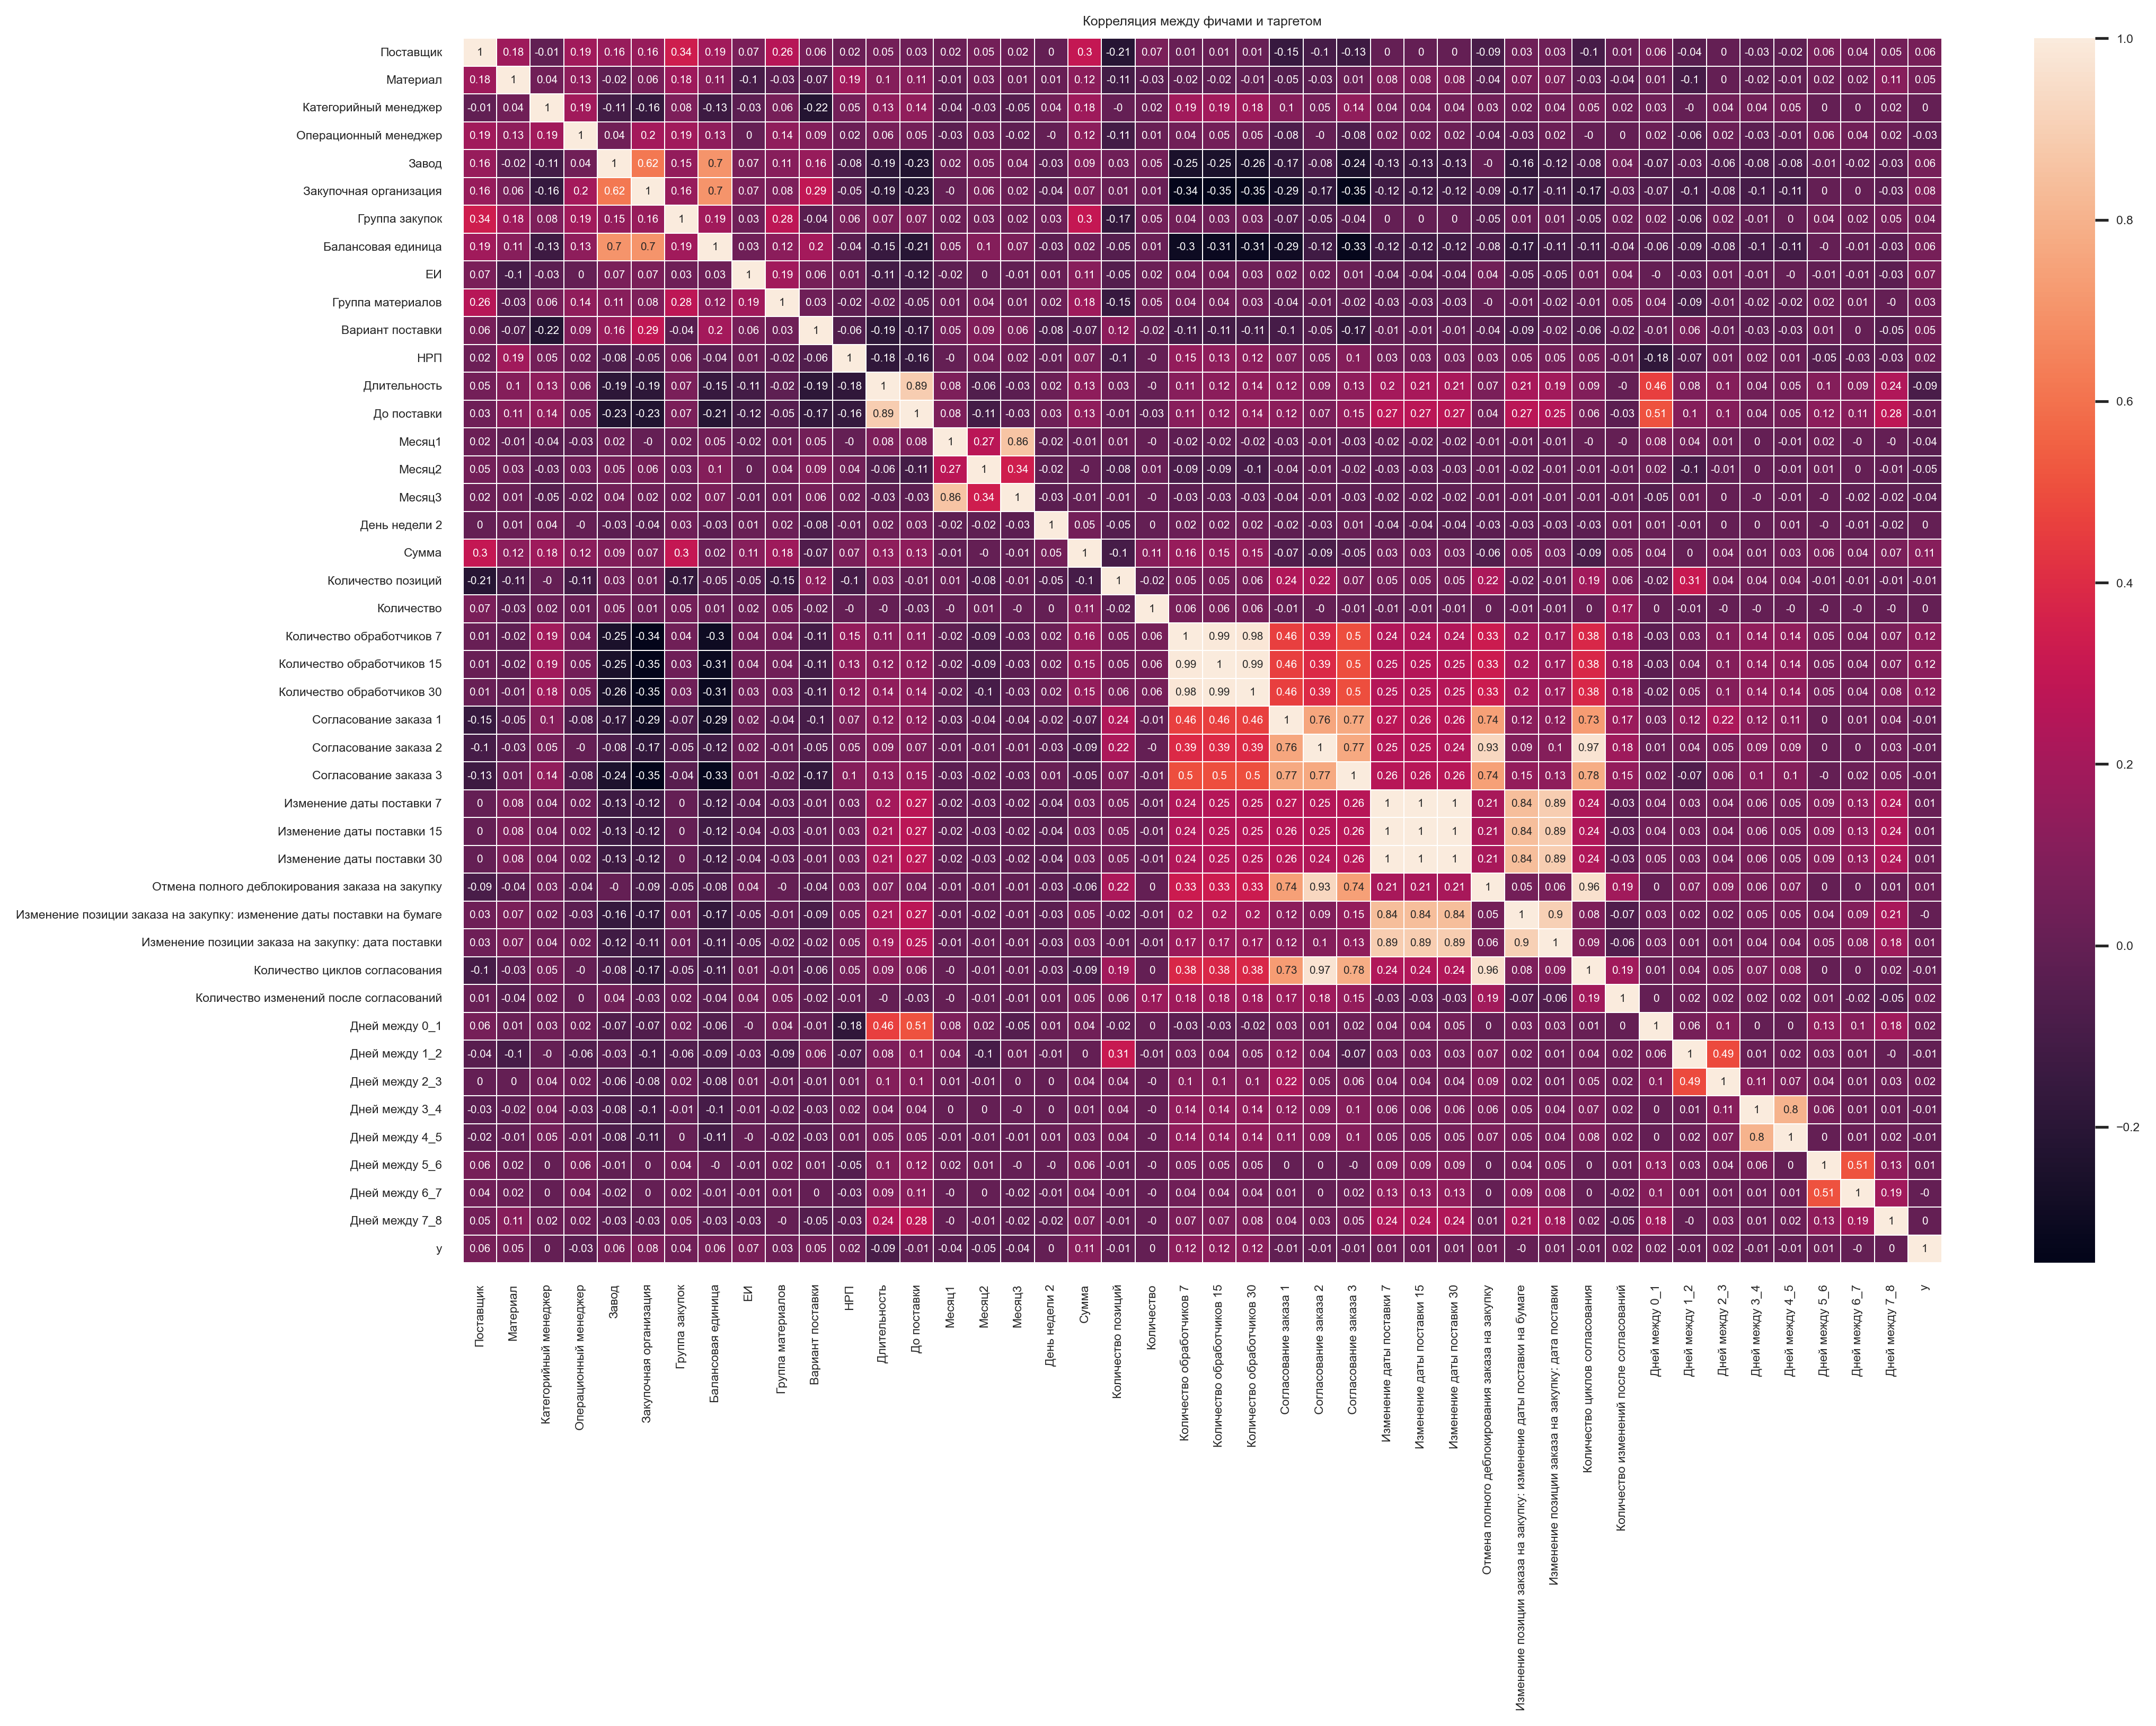

In [9]:
# Корреляция между фичами и таргетом
plt.figure(figsize=(15, 10), dpi=300)
sns.set(font_scale=0.5)
sns.heatmap(data=np.round(train_df.corr(), 2), linewidths=0.1, annot=True, annot_kws={'fontsize': 'small'})
plt.title('Корреляция между фичами и таргетом')
plt.show()

Видна корреляция таргета со следующими признаками: Поставщик, Материал, Завод, Закупочная организация, ЕИ, Группа закупок, Вариант поставки, Длительность, Месяц (1, 2, 3), Сумма, Количество обработчиков (7, 15, 30). Возможно, что корреляция с категориальными признаками переоценена, поэтому оценивать их значимость лучше на практике. Имеет смысл перевести некоторые временнЫе признаки в тригонометрическое представление (через sin/cos), ввиду их цикличности.

#### Распределение поставок среди поставщиков

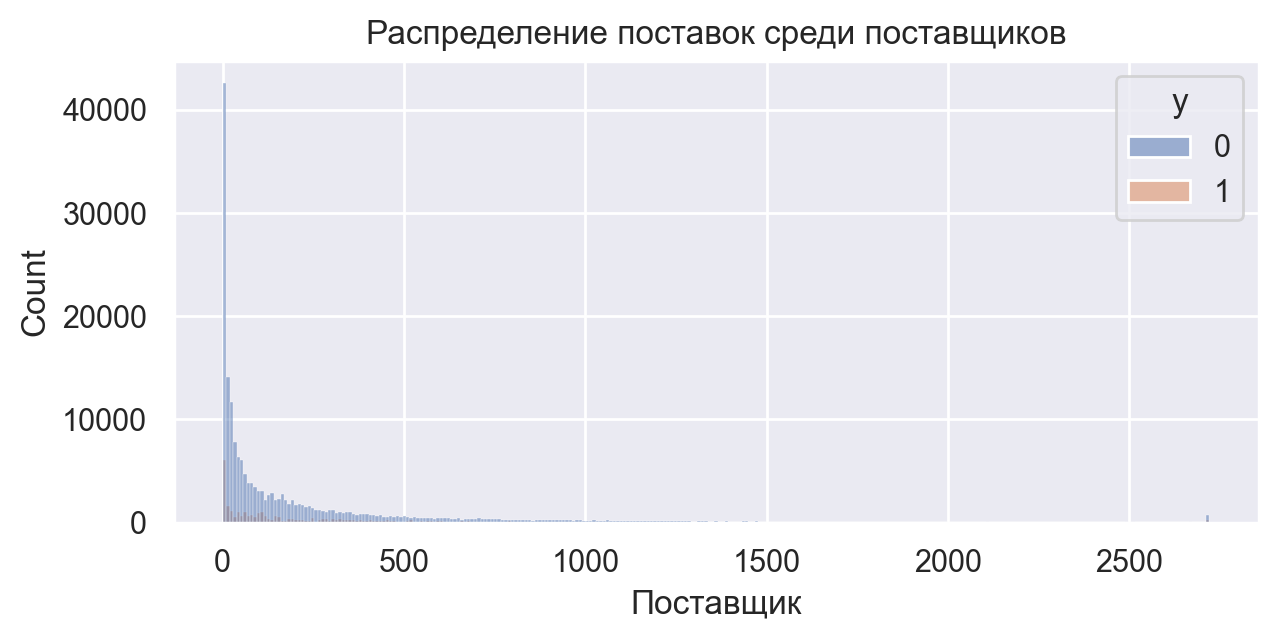

In [8]:
# Распределение поставок среди поставщиков
plt.figure(figsize=(7, 3), dpi=200)
sns.set(font_scale=1)
sns.histplot(data=train_df, x='Поставщик', hue='y')
plt.title('Распределение поставок среди поставщиков')
plt.show()

#### Распределение материалов среди поставок

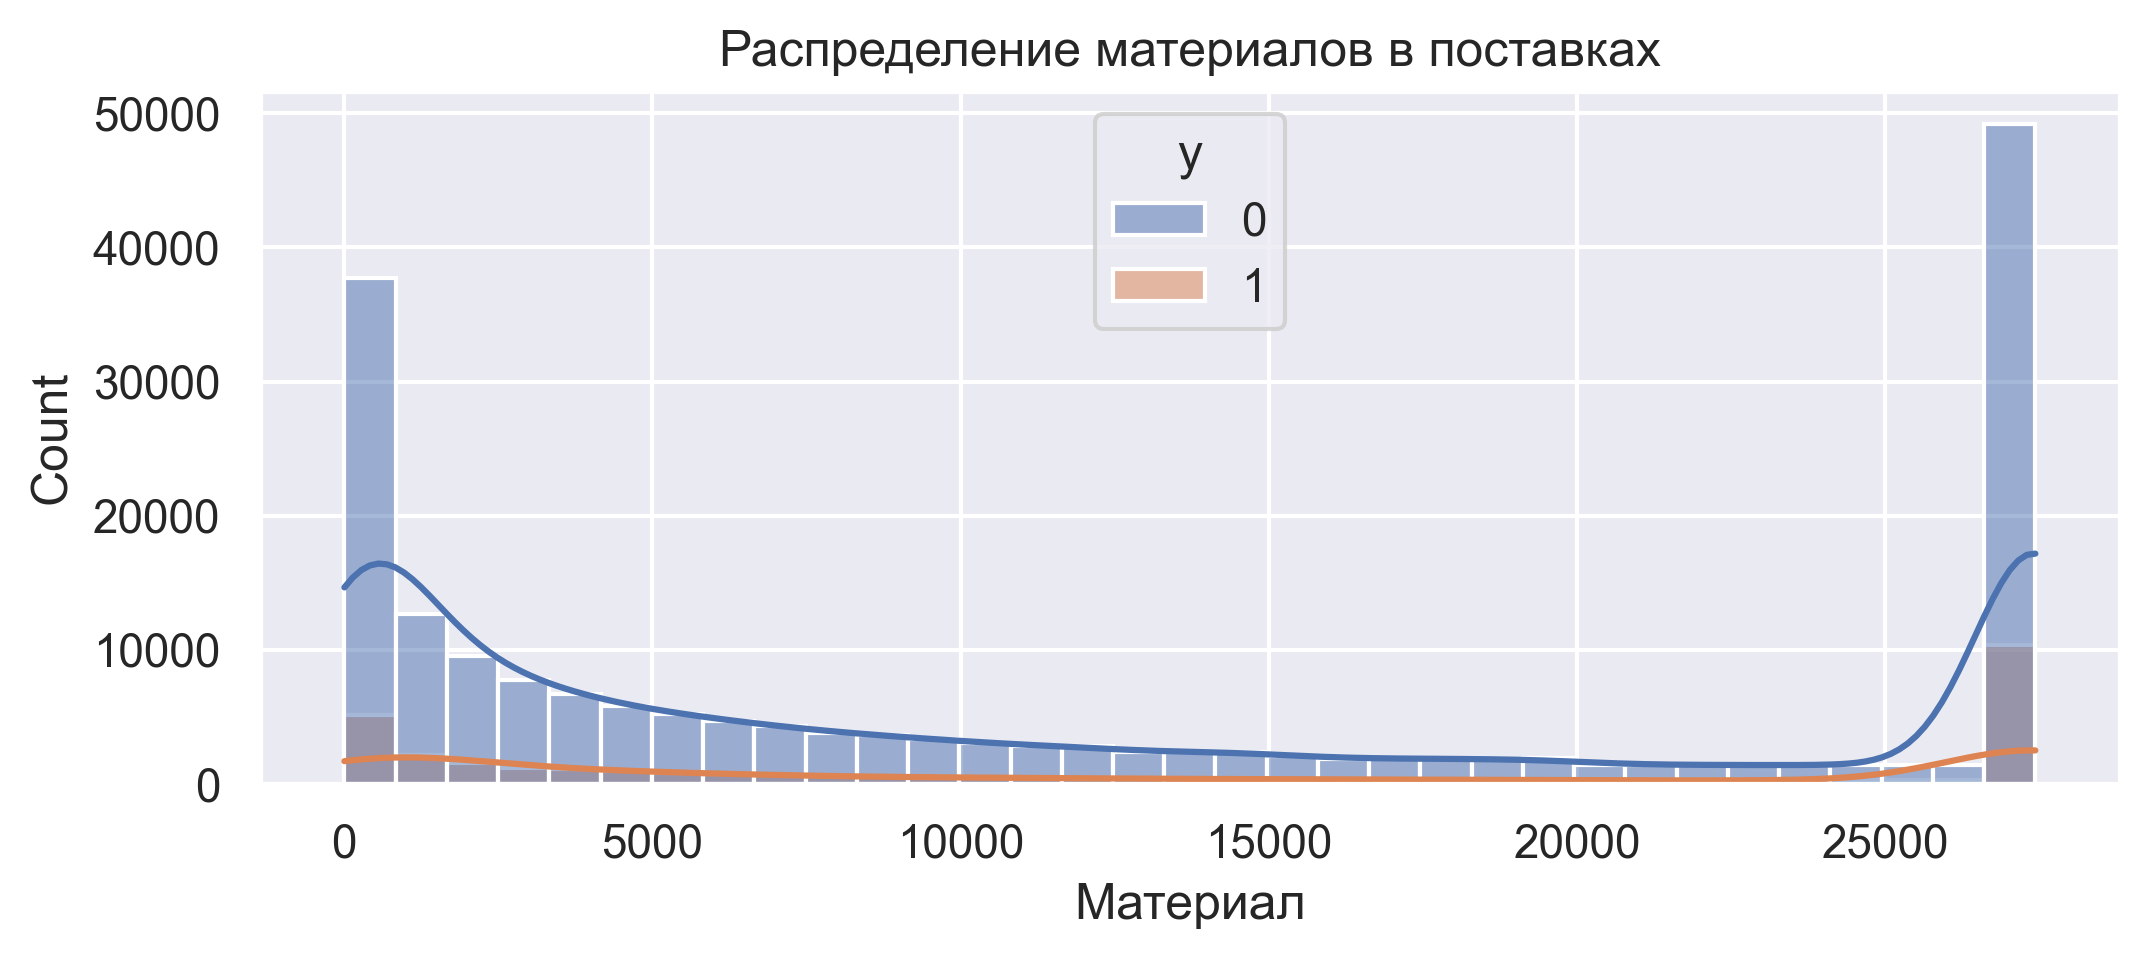

In [9]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Материал', hue='y', kde=True)
plt.title('Распределение материалов среди поставок')
plt.show()

#### Распределение сумм поставок

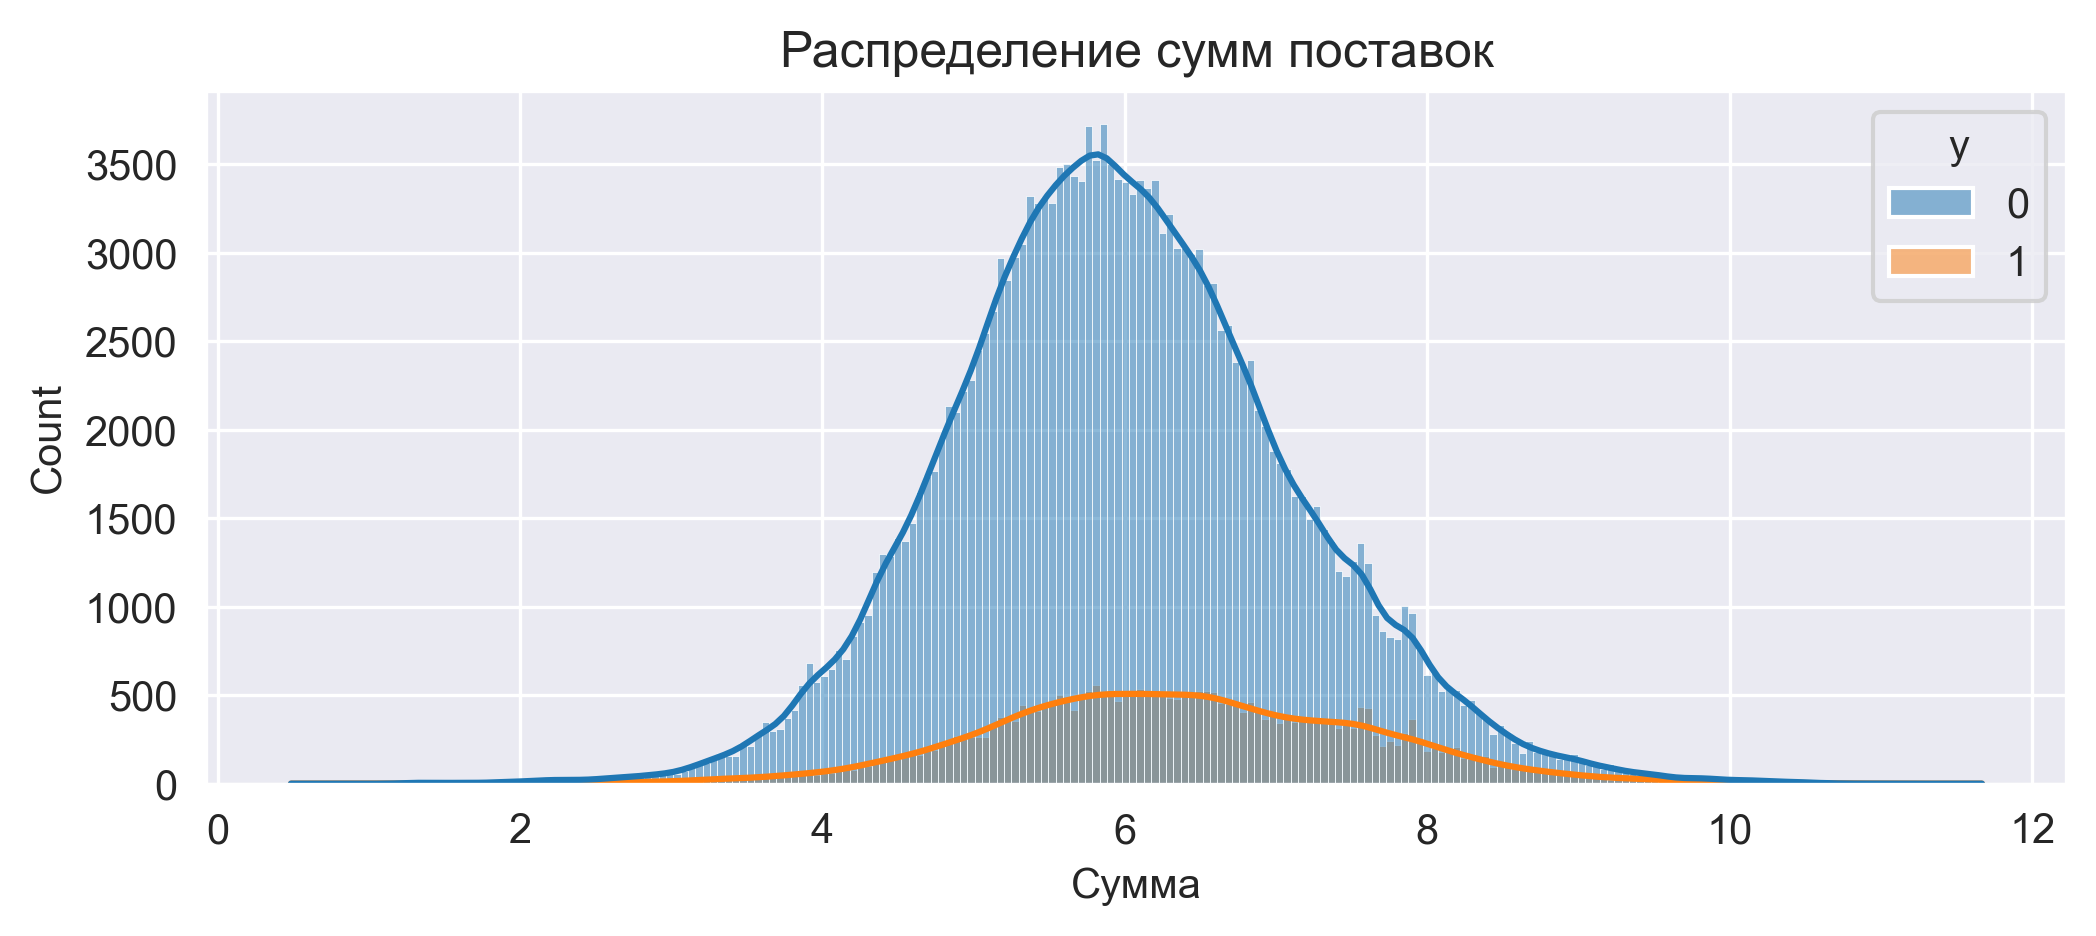

In [23]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Сумма', hue='y', kde=True)
plt.title('Распределение сумм поставок')
plt.show()

Это распределение является нормальным. С ростом суммы поставки растёт процент срывов. Количество поставок на сумму больше 6 начинает плавно уменьшаться, но соотношение успешных и сорванных сделок растёт. Лишь в особо крупных заказах процент срывов начинает уменьшаться, но можно сделать вывод, что при росте суммы увеличивается и процент срыва. Ту же закономерность можно наблюдать на тепловой карте, где корреляция между таргетом и суммой равняется ~0.11.

#### Распределение НРП среди поставок

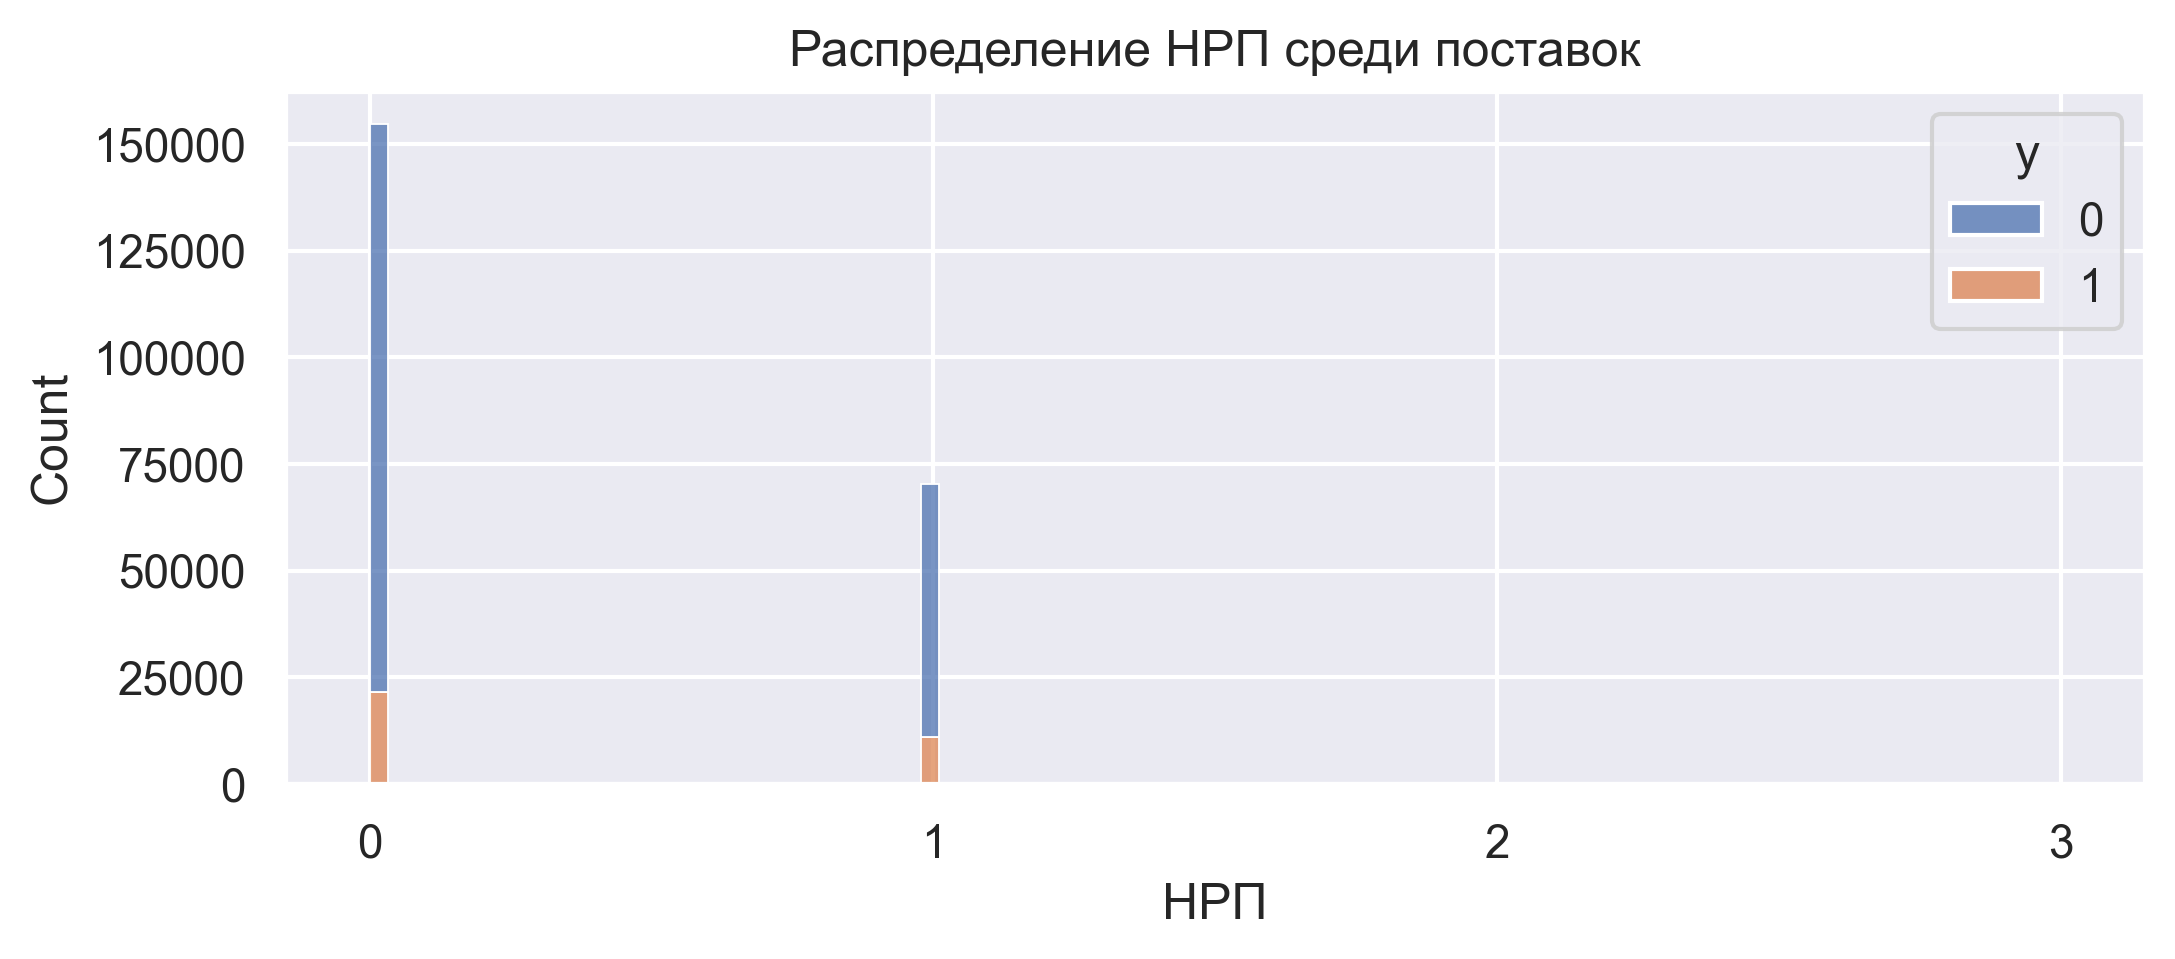

In [82]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='НРП', hue='y', multiple='stack')
plt.title('Распределение НРП среди поставок')
plt.xticks([0, 1, 2, 3])
plt.show()

In [38]:
train_df['НРП'].value_counts()

НРП
0.0    154762
1.0     70202
2.0        34
3.0         2
Name: count, dtype: int64

In [66]:
nrp1 = train_df[train_df['НРП'] == 1]
nrp0 = train_df[train_df['НРП'] == 0]
nrp0_0 = nrp0['y'].sum()
nrp0_0 / nrp0['y'].count()

0.1385417608973779

#### Распределение поставок по месяцам

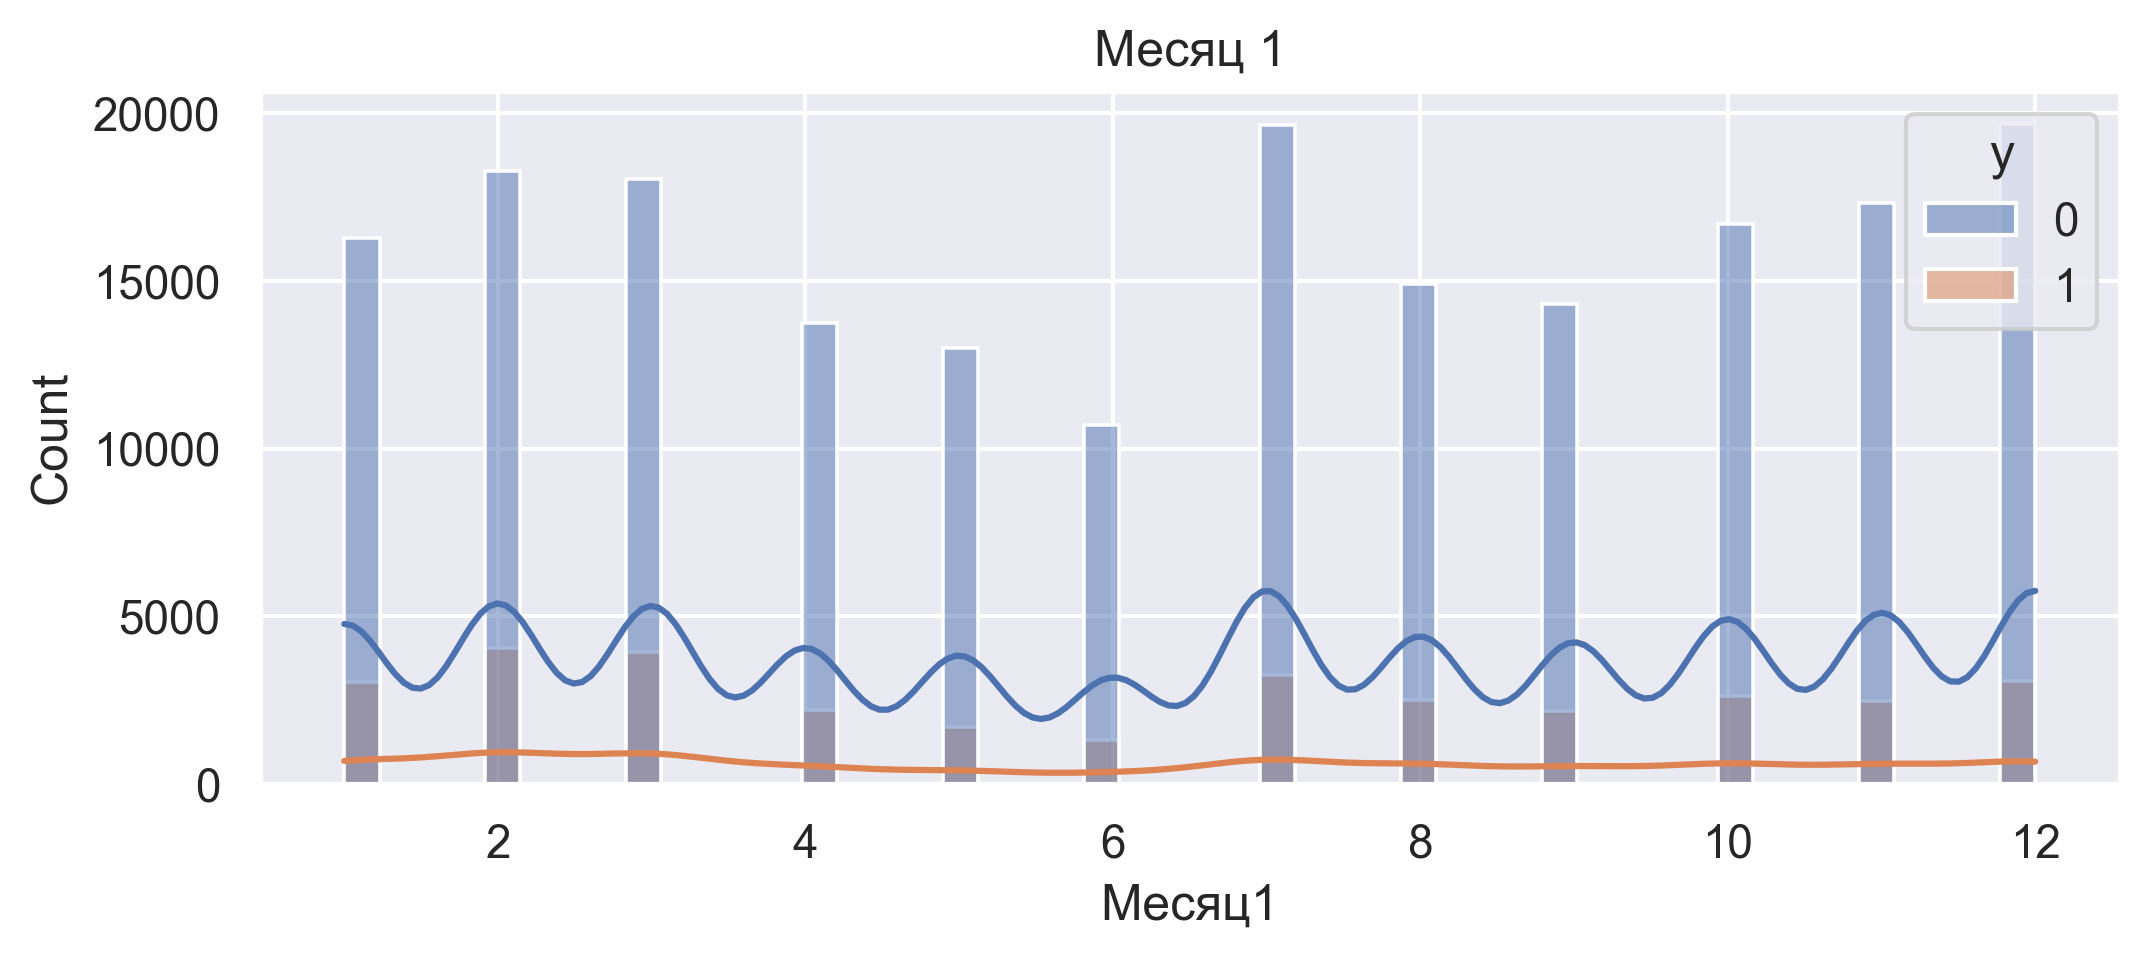

In [39]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Месяц1', hue='y', kde=True)
plt.title('Месяц 1')
plt.show()

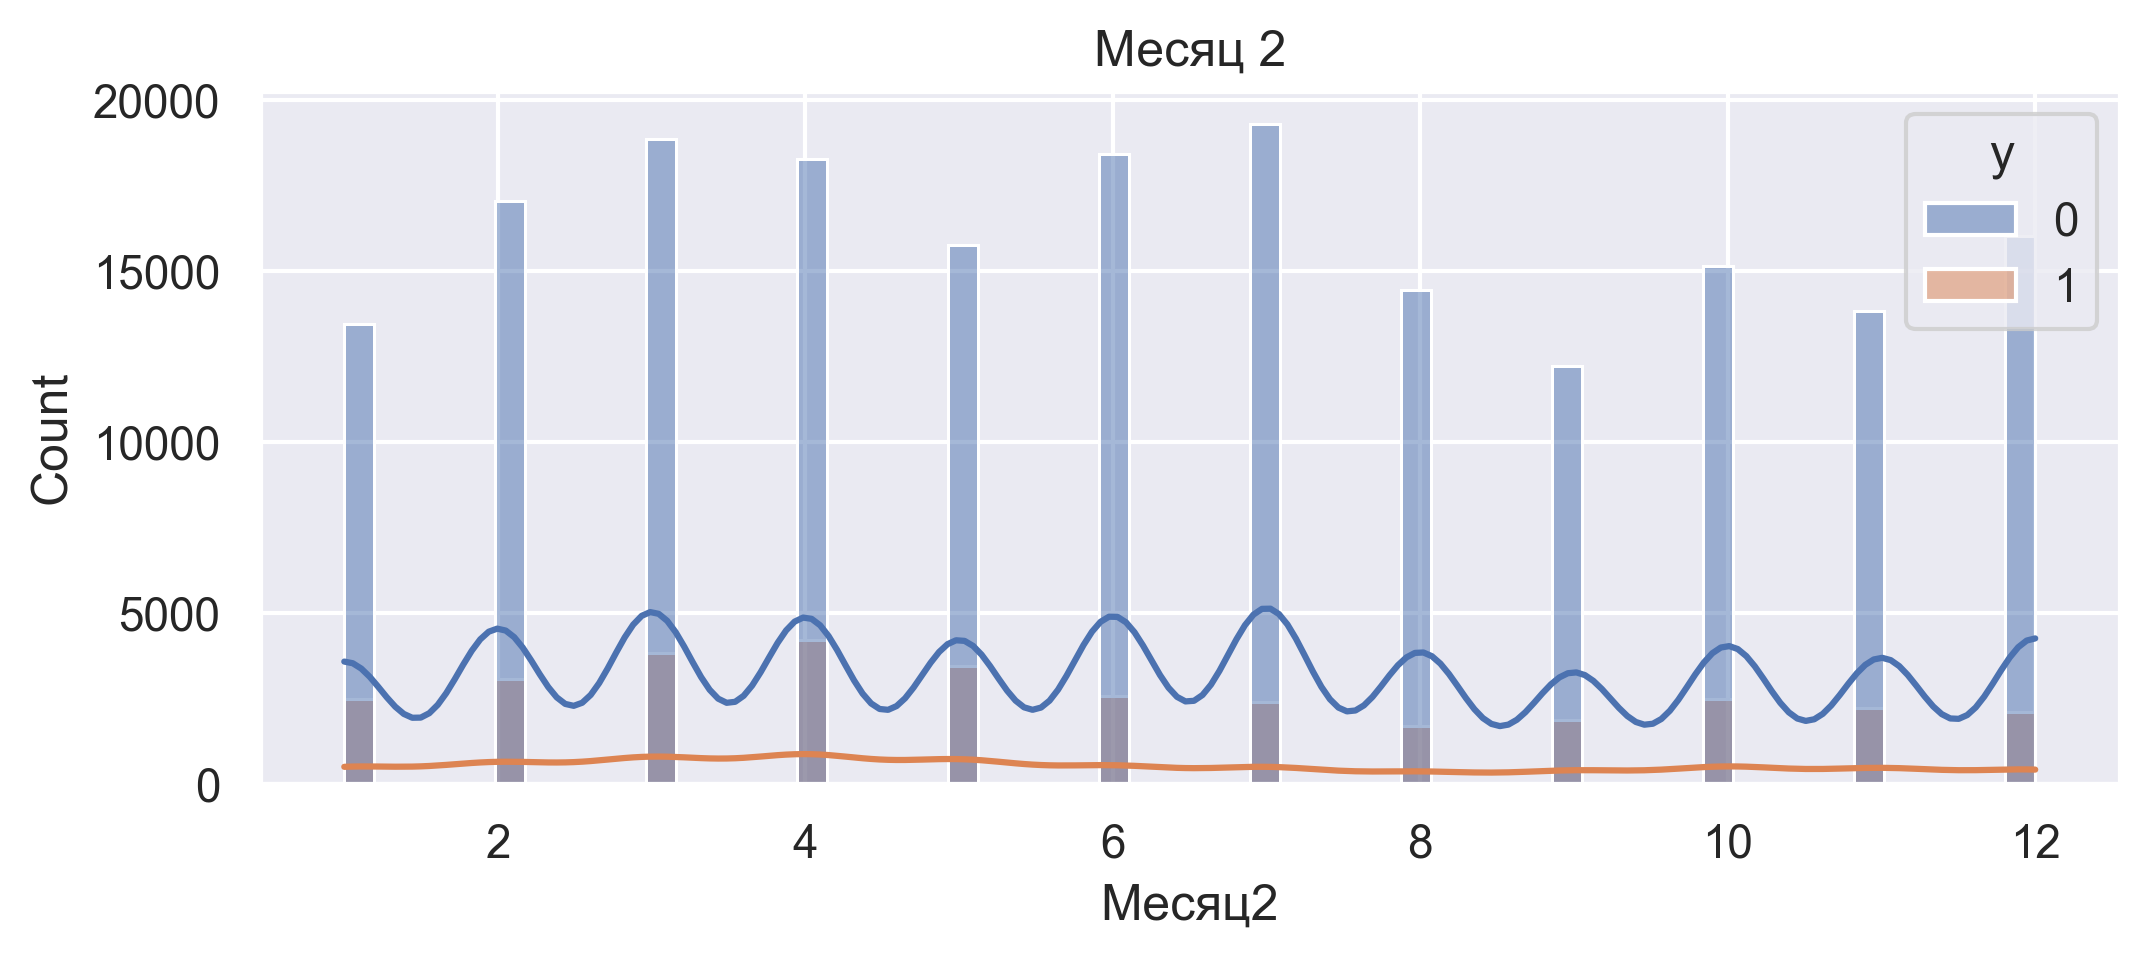

In [43]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Месяц2', hue='y', kde=True)
plt.title('Месяц 2')
plt.show()

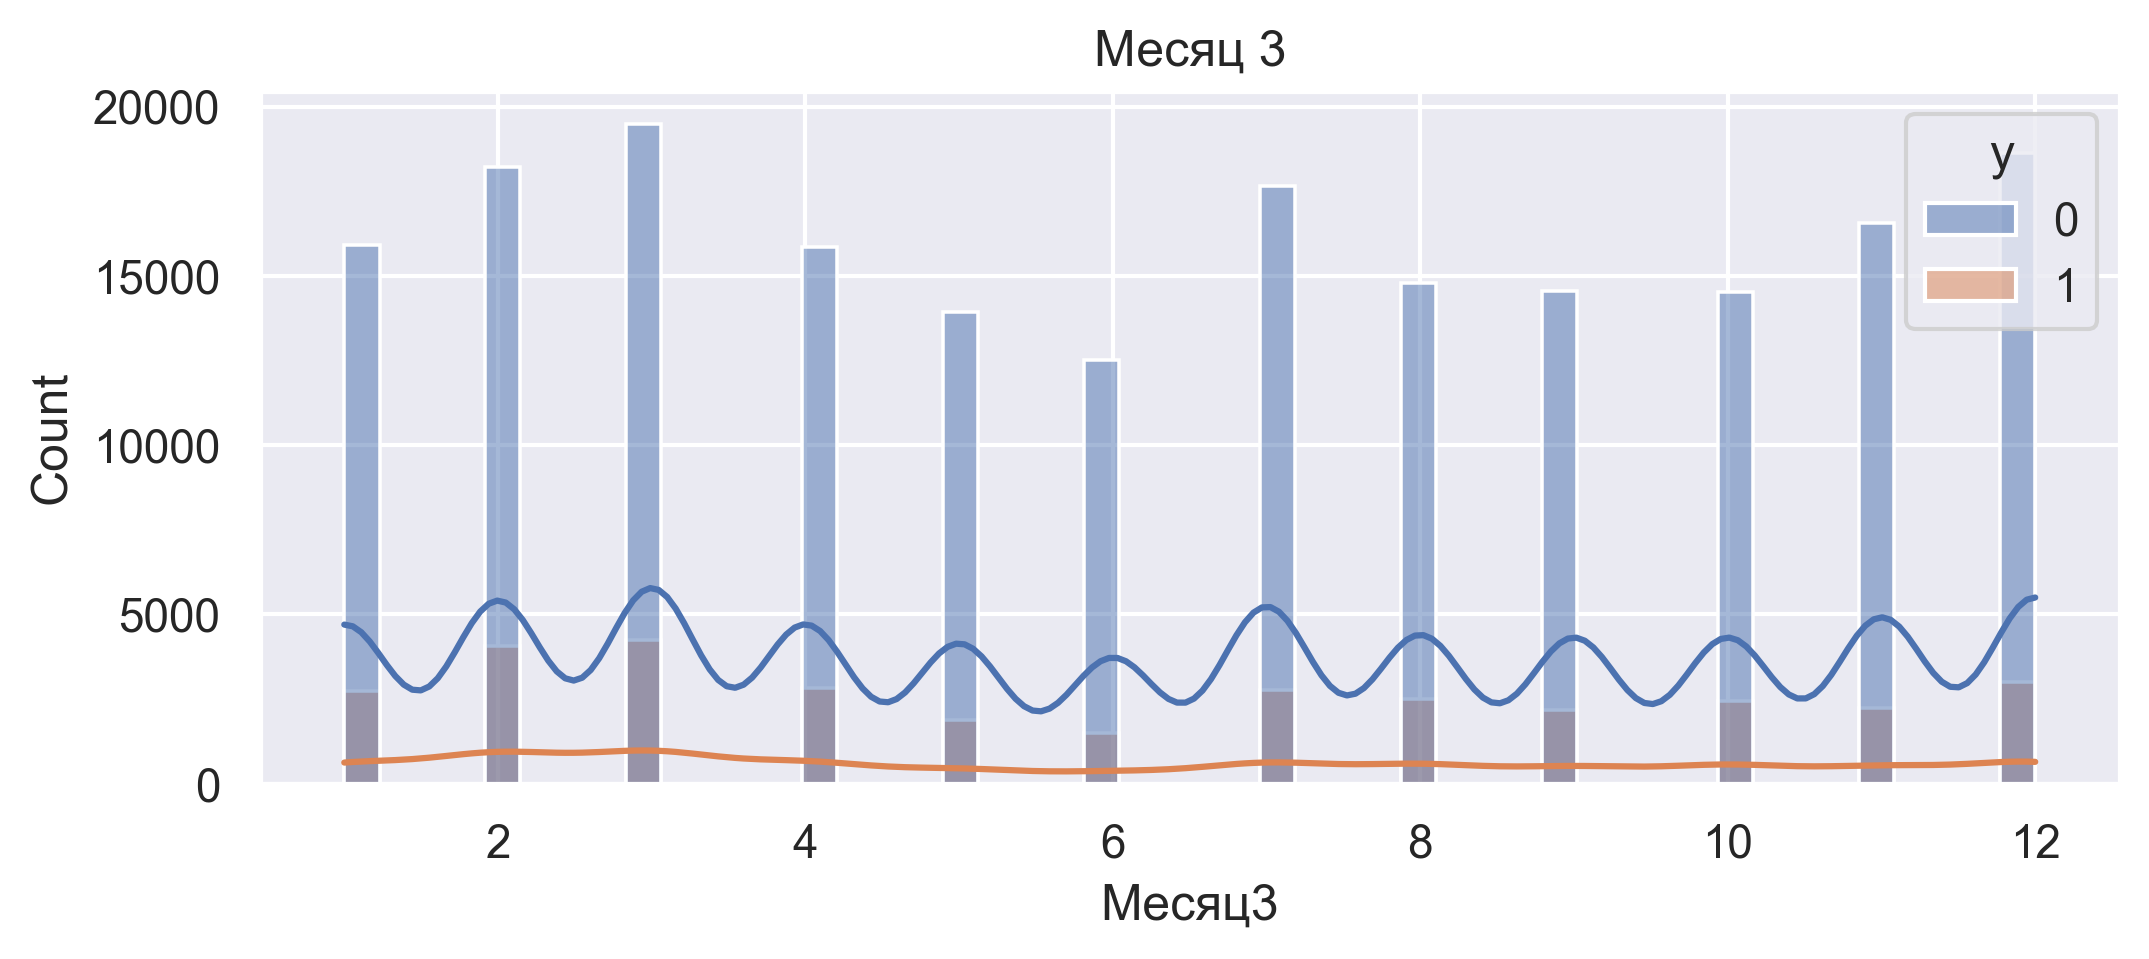

In [41]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Месяц3', hue='y', kde=True)
plt.title('Месяц 3')
plt.show()

#### Распределение длительности поставок

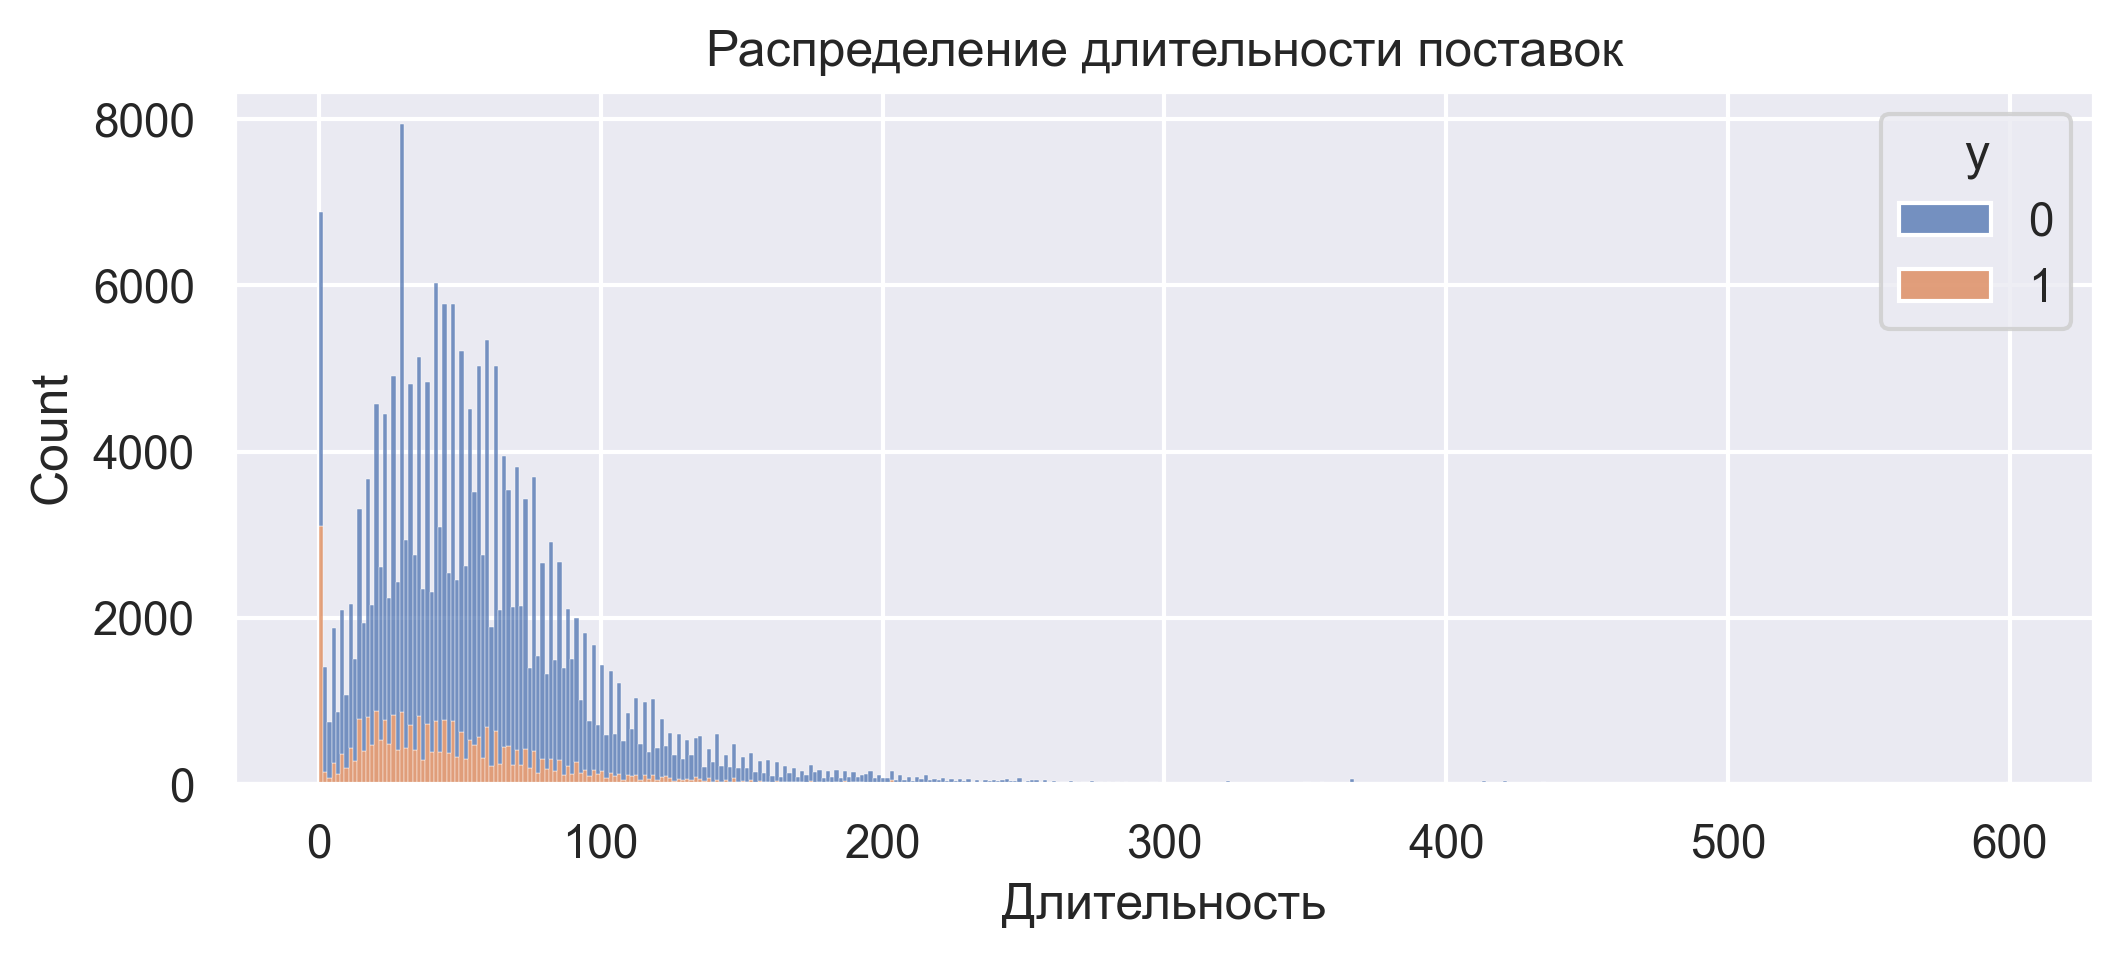

In [93]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Длительность', hue='y', multiple='stack')
plt.title('Распределение длительности поставок')
plt.show()

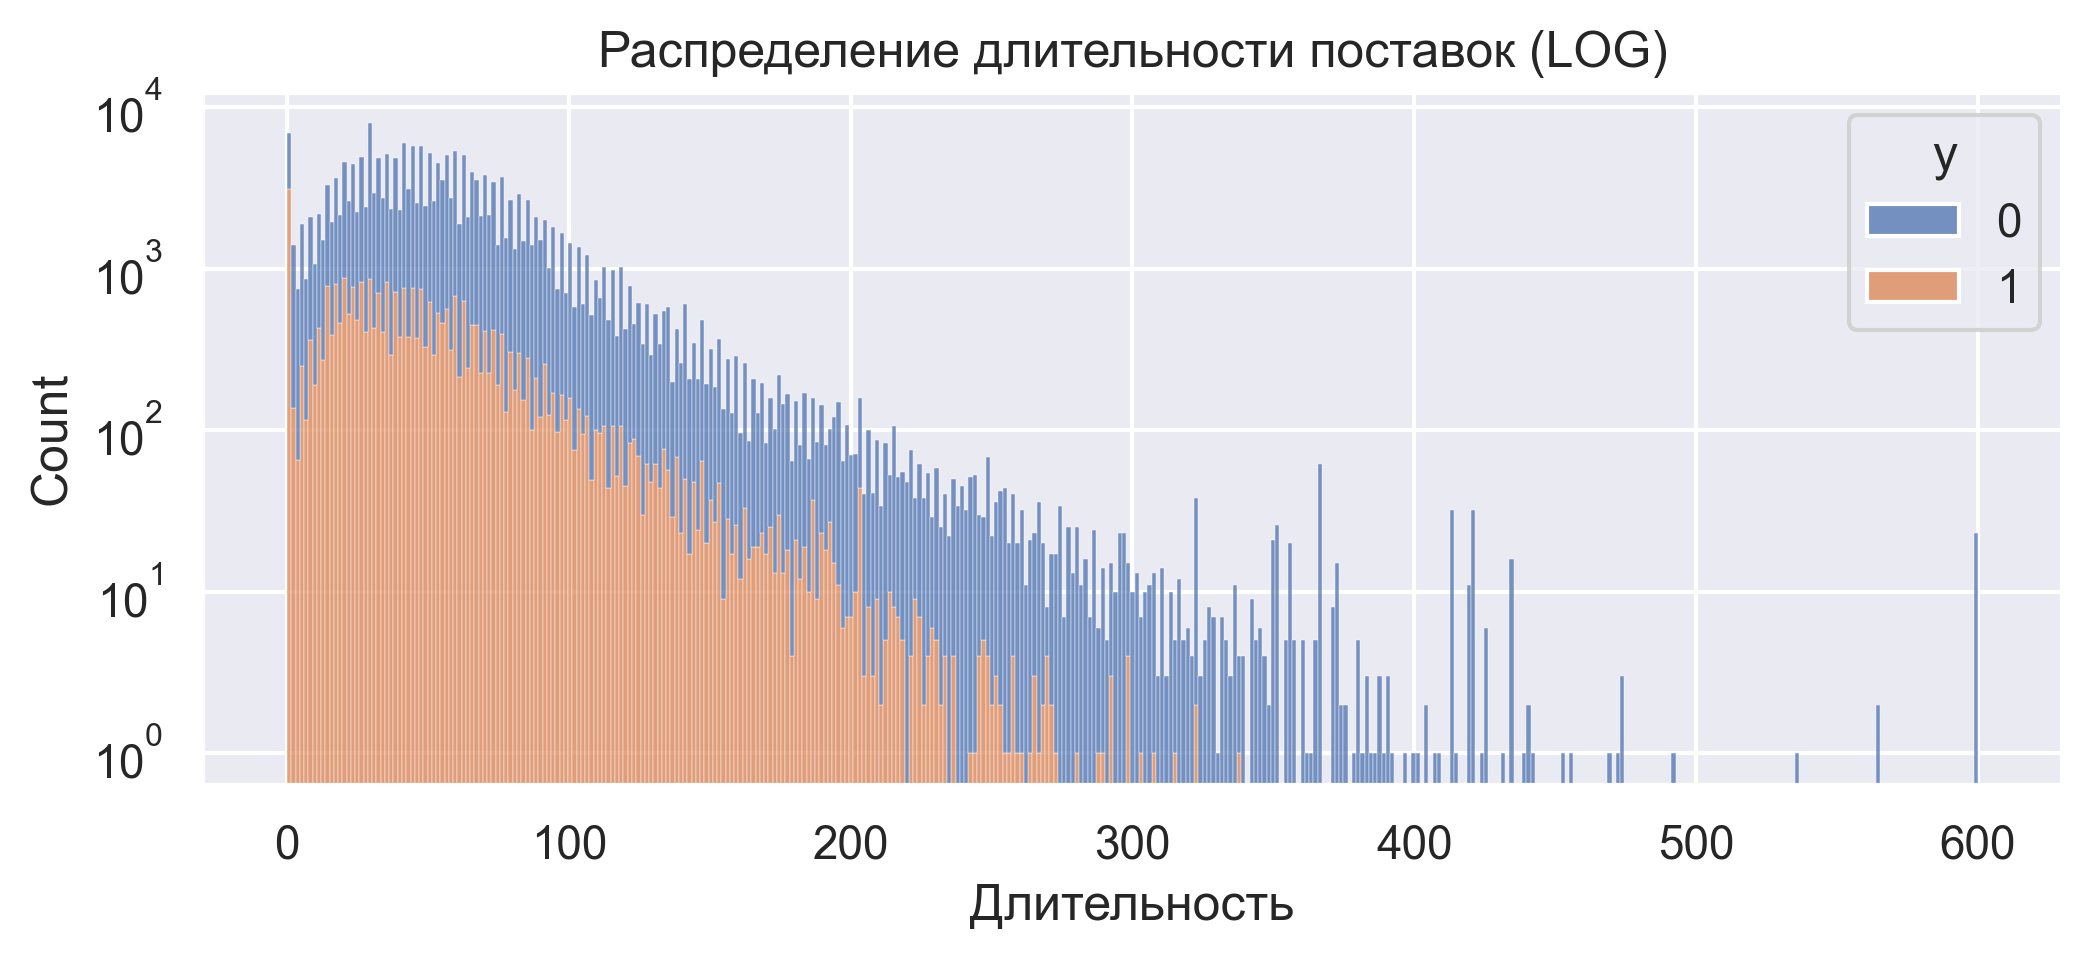

In [94]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Длительность', hue='y', multiple='stack')
plt.title('Распределение длительности поставок (LOG)')
plt.yscale('log')
plt.show()

#### Распределение поставок по дням недели

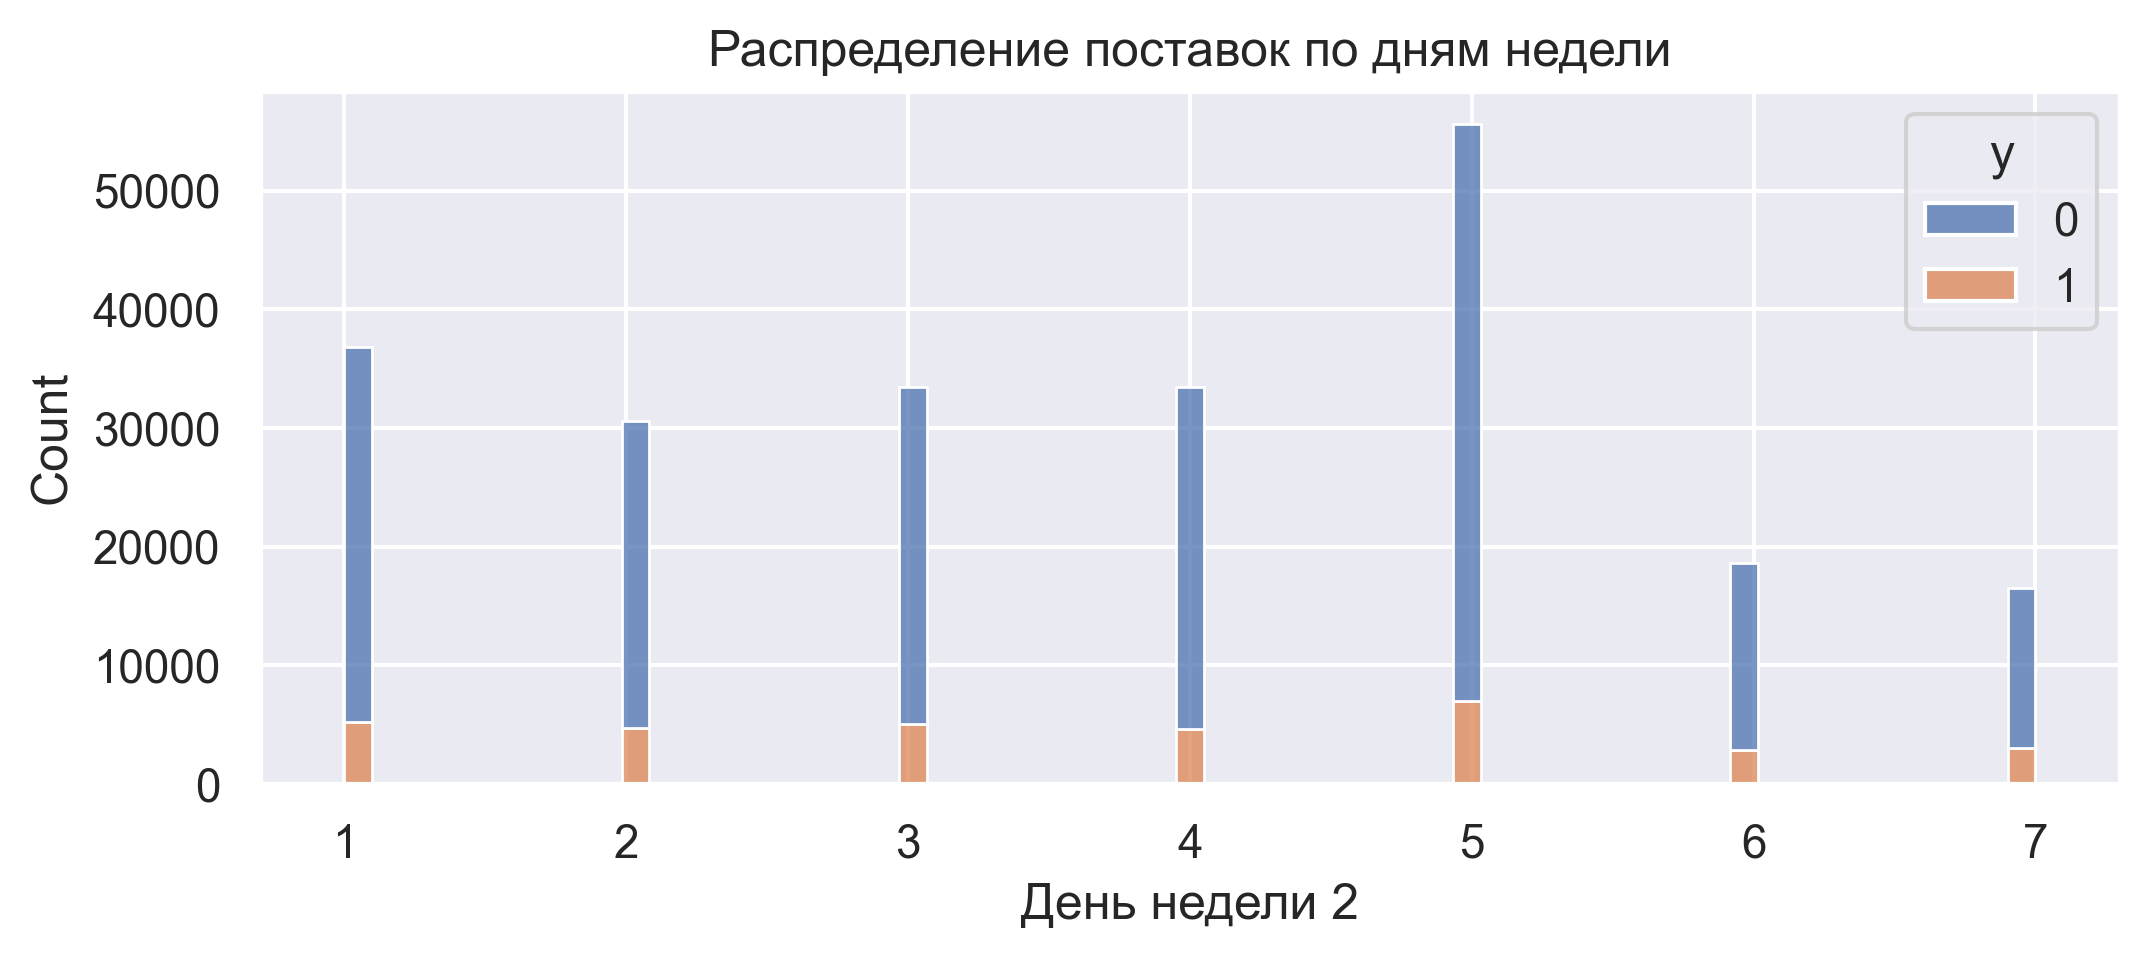

In [95]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x=train_df['День недели 2'] + 1, hue='y', multiple='stack')
plt.title('Распределение поставок по дням недели')
plt.show()

#### Распределение вариантов поставки

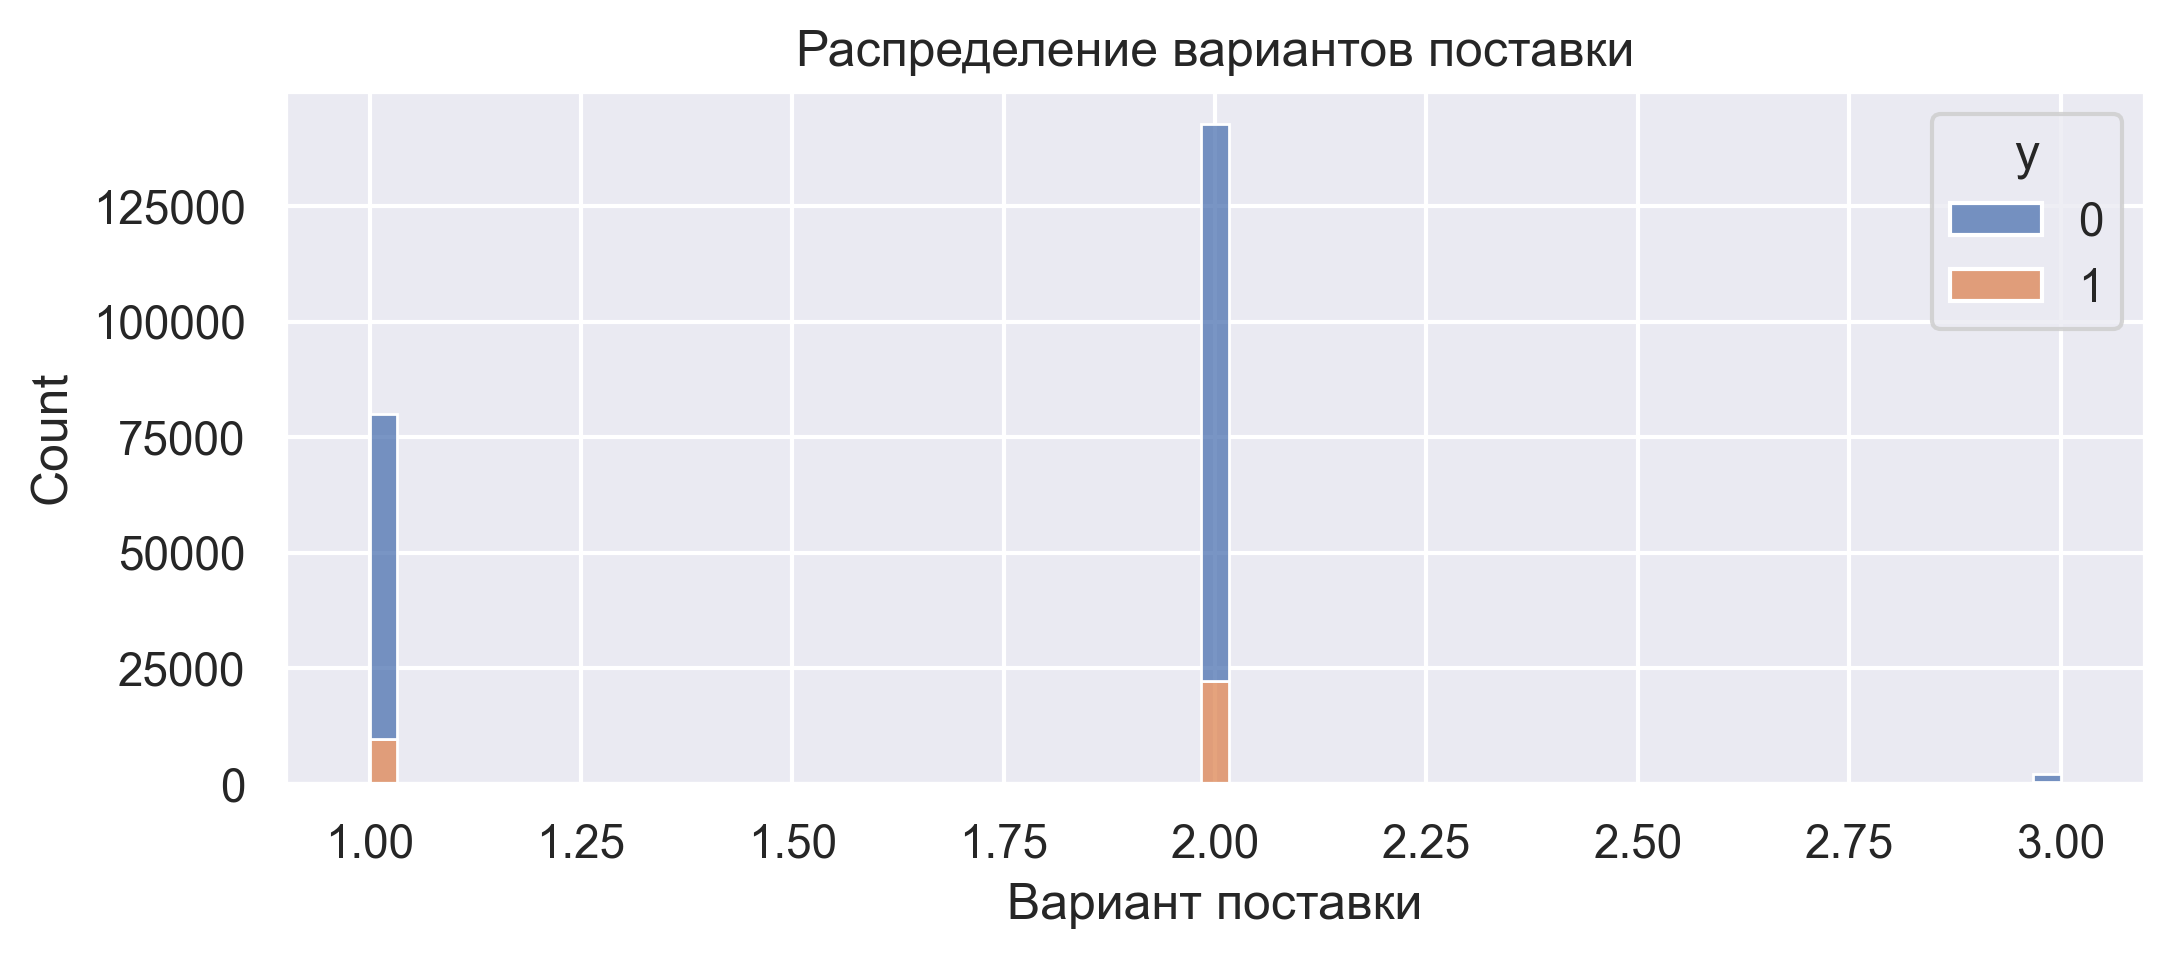

In [98]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Вариант поставки', hue='y', multiple='stack')
plt.title('Распределение вариантов поставки')
plt.show()

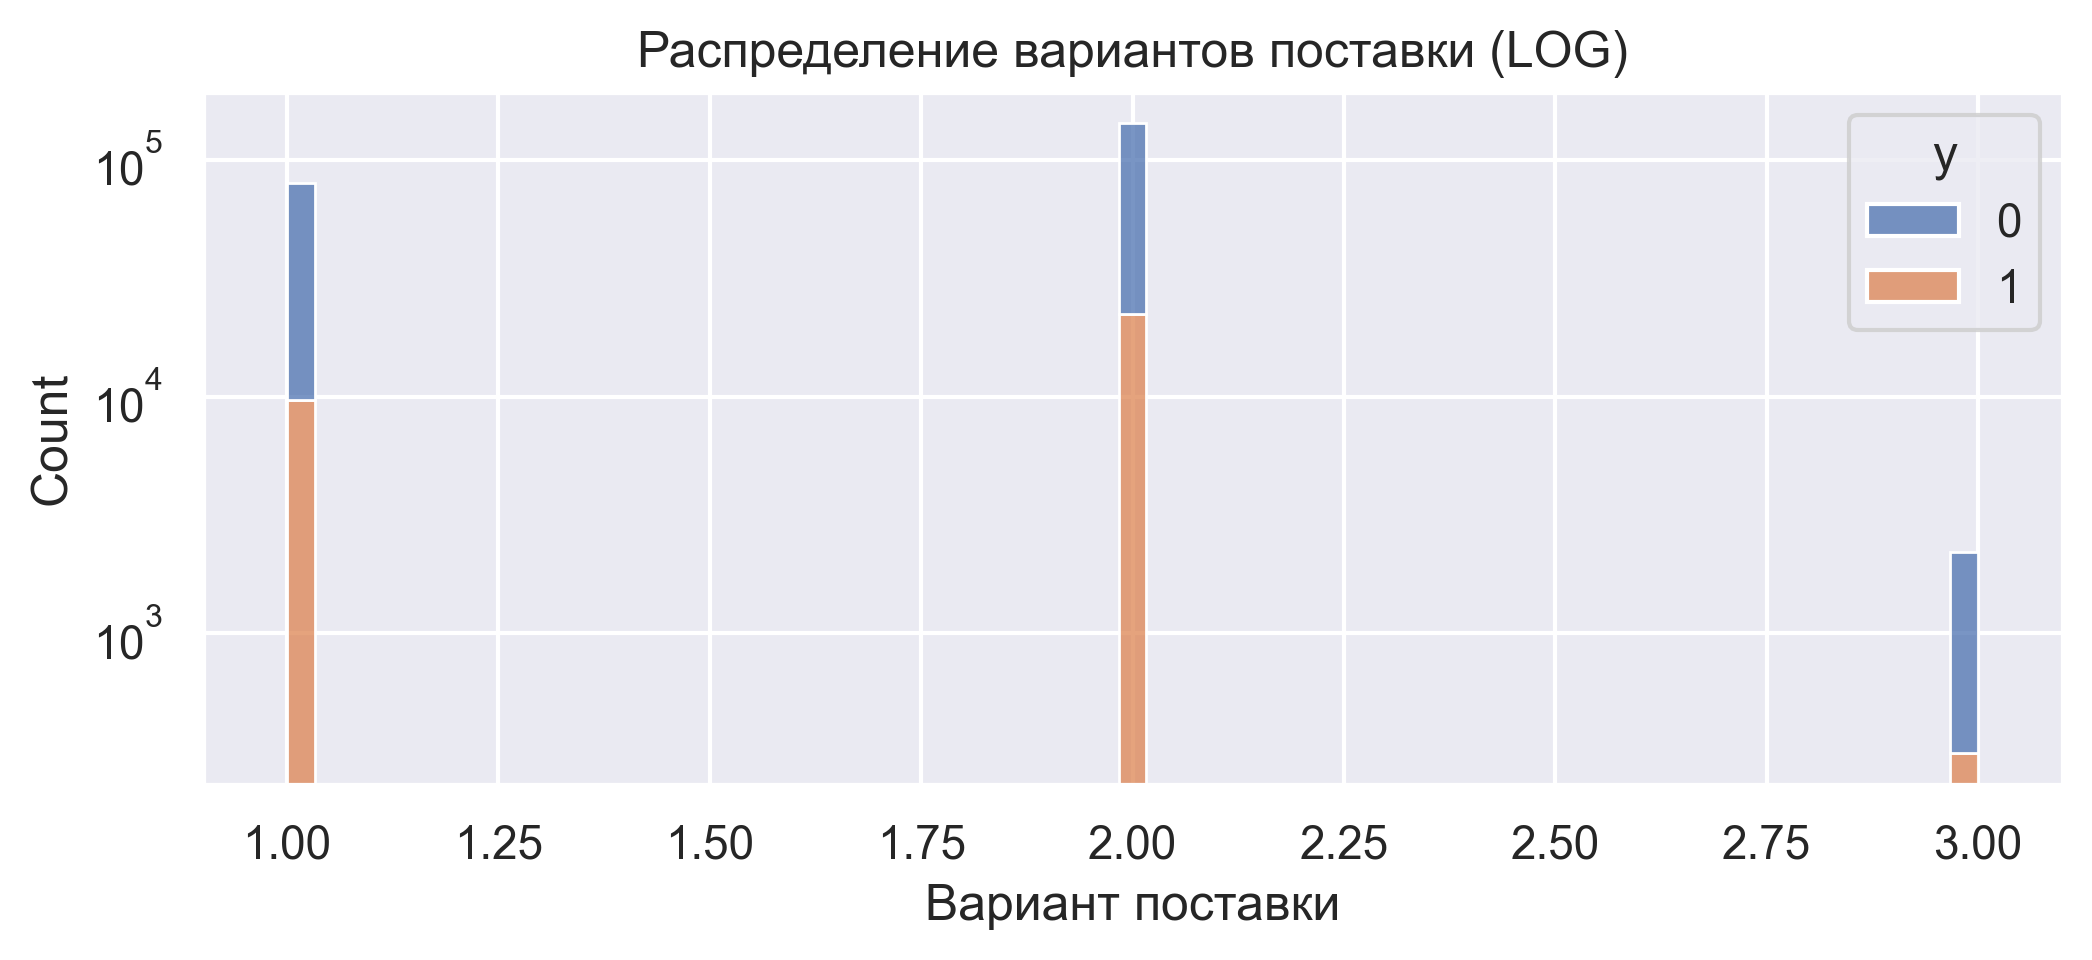

In [113]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Вариант поставки', hue='y', multiple='stack')
plt.title('Распределение вариантов поставки (LOG)')
plt.yscale('log')
plt.show()

#### Распределение количества материалов среди поставок

In [114]:
plt.figure(figsize=(8, 3))
sns.histplot(data=train_df, x='Количество', hue='y', multiple='stack')
plt.title('Распределение количества материалов среди поставок')
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001EADD18B7E0> (for post_execute):


KeyboardInterrupt: 

#### Распределение целевых классов

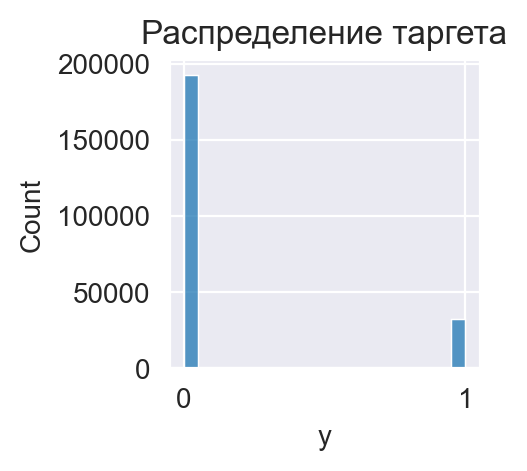

In [12]:
plt.figure(figsize=(2, 2), dpi=200)
sns.histplot(data=train_df, x='y')
plt.title('Распределение таргета')
plt.xticks([0, 1])
plt.show()

Виден значительный разрыв между представленными классами, что является особенностью данных (большее количество поставок успешно завершается), для кросс-валидации модели следует применять методы, включающие стратификацию данных, что повысит качество кросс-валидации и позволит получить достоверные результаты.

## Балансировка датасета

In [11]:
# Распределение до балансировки
print(f'Train distribution:\n{train_df["y"].value_counts()}')

Train distribution:
y
0    192663
1     32337
Name: count, dtype: int64


In [6]:
# Балансировка
positive_entries = train_df[train_df['y'] == 1]
negative_count = len(train_df[train_df['y'] == 0])
positive_count = len(positive_entries)
balanced_df = pd.concat([train_df, positive_entries])
for i in range(int(negative_count / positive_count) - 3):
    balanced_df = pd.concat([balanced_df, positive_entries])

In [7]:
# Распределение после балансировки
print(f'Train distribution:\n{balanced_df["y"].value_counts()}')
balanced_df.to_csv('data/balanced_train.csv')

Train distribution:
y
0    192663
1    129348
Name: count, dtype: int64


## Оценка признаков

## Обучение модели